In [1]:
from theano.sandbox import cuda

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


In [2]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [3]:
#path = "data/ml-20m/"
path = "data/ml-latest-small/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [4]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

In [6]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [7]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [8]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [9]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [10]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [11]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

This is the number of latent factors in each embedding.

In [12]:
n_factors = 50

In [13]:
np.random.seed = 42

Randomly split into training and validation.

In [14]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [15]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

In [16]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [17]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')

In [18]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [19]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [20]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)

In [21]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [22]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

In [22]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, verbose=2,
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79769 samples, validate on 20235 samples
Epoch 1/1
7s - loss: 9.8651 - val_loss: 4.2757


In [23]:
model.optimizer.lr=0.01

In [24]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=3, verbose=2,
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79769 samples, validate on 20235 samples
Epoch 1/3
7s - loss: 3.1193 - val_loss: 2.8432
Epoch 2/3
7s - loss: 2.4168 - val_loss: 2.6456
Epoch 3/3
7s - loss: 2.2601 - val_loss: 2.5969


In [25]:
model.optimizer.lr=0.001

In [26]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6,verbose=2, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79769 samples, validate on 20235 samples
Epoch 1/6
7s - loss: 2.2023 - val_loss: 2.5865
Epoch 2/6
7s - loss: 2.1701 - val_loss: 2.5819
Epoch 3/6
7s - loss: 2.1431 - val_loss: 2.5805
Epoch 4/6
7s - loss: 2.1187 - val_loss: 2.5849
Epoch 5/6
7s - loss: 2.0939 - val_loss: 2.5858
Epoch 6/6
7s - loss: 2.0725 - val_loss: 2.5861


The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [27]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [28]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [29]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [30]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [31]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [32]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, verbose=2,
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79769 samples, validate on 20235 samples
Epoch 1/1
6s - loss: 8.8997 - val_loss: 3.5640


In [33]:
model.optimizer.lr=0.01

In [34]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, verbose=2,
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79769 samples, validate on 20235 samples
Epoch 1/6
6s - loss: 2.5965 - val_loss: 2.3261
Epoch 2/6
6s - loss: 1.9977 - val_loss: 2.1258
Epoch 3/6
6s - loss: 1.8354 - val_loss: 2.0307
Epoch 4/6
6s - loss: 1.7412 - val_loss: 1.9562
Epoch 5/6
6s - loss: 1.6608 - val_loss: 1.8861
Epoch 6/6
6s - loss: 1.5874 - val_loss: 1.8157


In [35]:
model.optimizer.lr=0.001

In [36]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=10, verbose=2,
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79769 samples, validate on 20235 samples
Epoch 1/10
6s - loss: 1.5143 - val_loss: 1.7560
Epoch 2/10
6s - loss: 1.4443 - val_loss: 1.6965
Epoch 3/10
6s - loss: 1.3767 - val_loss: 1.6384
Epoch 4/10
6s - loss: 1.3107 - val_loss: 1.5840
Epoch 5/10
6s - loss: 1.2471 - val_loss: 1.5274
Epoch 6/10
6s - loss: 1.1858 - val_loss: 1.4780
Epoch 7/10
6s - loss: 1.1280 - val_loss: 1.4316
Epoch 8/10
6s - loss: 1.0728 - val_loss: 1.3918
Epoch 9/10
6s - loss: 1.0201 - val_loss: 1.3457
Epoch 10/10
6s - loss: 0.9709 - val_loss: 1.3076


In [37]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5,  verbose=2,
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79769 samples, validate on 20235 samples
Epoch 1/5
6s - loss: 0.9240 - val_loss: 1.2716
Epoch 2/5
6s - loss: 0.8811 - val_loss: 1.2389
Epoch 3/5
6s - loss: 0.8403 - val_loss: 1.2093
Epoch 4/5
6s - loss: 0.8030 - val_loss: 1.1830
Epoch 5/5
6s - loss: 0.7686 - val_loss: 1.1593


This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!

In [38]:
model.save_weights(model_path+'bias.h5')

In [39]:
model.load_weights(model_path+'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [40]:
model.predict([np.array([3]), np.array([6])])

array([[ 4.8451]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [41]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [42]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [43]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.30736509, 'Battlefield Earth (2000)'),
 (-0.08534991, 'Super Mario Bros. (1993)'),
 (-0.055968657, 'Police Academy 3: Back in Training (1986)'),
 (-0.032860946, 'Jaws 3-D (1983)'),
 (0.019542074, 'Spice World (1997)'),
 (0.030156091, '2 Fast 2 Furious (Fast and the Furious 2, The) (2003)'),
 (0.046630718, 'Police Academy 6: City Under Siege (1989)'),
 (0.04889201, 'Blade: Trinity (2004)'),
 (0.07088232, 'Scooby-Doo (2002)'),
 (0.073758721, 'Wild Wild West (1999)'),
 (0.074506208, 'Little Nicky (2000)'),
 (0.083454765, 'Speed 2: Cruise Control (1997)'),
 (0.090444908, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (0.099202469, 'Blair Witch Project, The (1999)'),
 (0.099454589, 'Hollow Man (2000)')]

In [44]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.4080991, 'Rush (2013)'),
 (1.3905334, '3:10 to Yuma (2007)'),
 (1.350913, 'Harry Potter and the Deathly Hallows: Part 2 (2011)'),
 (1.3357903, 'Porco Rosso (Crimson Pig) (Kurenai no buta) (1992)'),
 (1.3262634, 'Captain America: The Winter Soldier (2014)'),
 (1.3177209, 'Argo (2012)'),
 (1.3094455, 'Shawshank Redemption, The (1994)'),
 (1.3055408, 'My Neighbor Totoro (Tonari no Totoro) (1988)'),
 (1.3025401, 'Midnight in Paris (2011)'),
 (1.3013011, 'Frankenstein (1931)'),
 (1.2794805, "Howl's Moving Castle (Hauru no ugoku shiro) (2004)"),
 (1.2792304, 'Tom Jones (1963)'),
 (1.2758468, 'High Noon (1952)'),
 (1.2738901, 'Grave of the Fireflies (Hotaru no haka) (1988)'),
 (1.2738613, 'Cyrano de Bergerac (1990)')]

We can now do the same thing for the embeddings.

In [45]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [46]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [47]:
fac0 = movie_pca[0]

In [48]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [49]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.051985560093628251, 'Usual Suspects, The (1995)'),
 (0.05137414559624958, 'American Beauty (1999)'),
 (0.050625577347186604, 'Wallace & Gromit: The Wrong Trousers (1993)'),
 (0.050056712798406386, "Schindler's List (1993)"),
 (0.049717406684557548, 'Seven (a.k.a. Se7en) (1995)'),
 (0.049456648267330088, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.049083221191121303,
  'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (0.048694762530705732,
  "Amelie (Fabuleux destin d'Am\xc3\xa9lie Poulain, Le) (2001)"),
 (0.048529681541770044, 'Wallace & Gromit: A Close Shave (1995)'),
 (0.048483405554401893, 'Godfather, The (1972)')]

In [50]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.014322819678388705, 'Grease 2 (1982)'),
 (-0.012116586387886027, 'Battlefield Earth (2000)'),
 (-0.0093097085440408279, 'Anaconda (1997)'),
 (-0.0085913344496866065, 'Police Academy 3: Back in Training (1986)'),
 (-0.0085080818603093314, 'House on Haunted Hill (1999)'),
 (-0.0084465922199756151, 'Blade: Trinity (2004)'),
 (-0.0083177235456859955, 'Howard the Duck (1986)'),
 (-0.0072302089042920632,
  'Highlander III: The Sorcerer (a.k.a. Highlander: The Final Dimension) (1994)'),
 (-0.0071557254945094472, "You Don't Mess with the Zohan (2008)"),
 (-0.0069563245120976905, 'Bachelor, The (1999)')]

In [51]:
fac1 = movie_pca[1]

In [52]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [53]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.098092257750167833, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.090318432936683068, 'Armageddon (1998)'),
 (0.086957189371522872, 'Jurassic Park (1993)'),
 (0.072233656539941724, 'Ghost (1990)'),
 (0.069662132569915741, 'Speed (1994)'),
 (0.069222931400631724, 'Stargate (1994)'),
 (0.068144114069679559, 'Titanic (1997)'),
 (0.066746849271724168, 'Home Alone (1990)'),
 (0.065556542444956983, 'Outbreak (1995)'),
 (0.065478704876598195, 'American President, The (1995)')]

In [54]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.066199679787609808, '2001: A Space Odyssey (1968)'),
 (-0.062928775111271679, 'Clockwork Orange, A (1971)'),
 (-0.059588702394507469, 'City Lights (1931)'),
 (-0.055879514922603339, 'Apocalypse Now (1979)'),
 (-0.055845818346926236, 'Sex, Lies, and Videotape (1989)'),
 (-0.055668241336685971,
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)'),
 (-0.054388476617166913, 'Taxi Driver (1976)'),
 (-0.053301953260533518, 'Big Lebowski, The (1998)'),
 (-0.05195795352918596, 'Remains of the Day, The (1993)'),
 (-0.051764013282627891, 'Manhattan (1979)')]

In [55]:
fac2 = movie_pca[2]

In [56]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [57]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.098025310596505988, 'Mrs. Doubtfire (1993)'),
 (0.092756076434107632, "Schindler's List (1993)"),
 (0.092414798268816392, 'Dances with Wolves (1990)'),
 (0.092116466616715881, 'Rob Roy (1995)'),
 (0.086821984270770397, 'Silence of the Lambs, The (1991)'),
 (0.086755544983653801, 'Babe (1995)'),
 (0.086250447449777778, 'Fugitive, The (1993)'),
 (0.086064780287700537, 'Fargo (1996)'),
 (0.078868023065367193, 'Ghost (1990)'),
 (0.077165860099372194, 'Lion King, The (1994)')]

In [58]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.074271610680565231, 'Dirty Rotten Scoundrels (1988)'),
 (-0.068002152202888605, 'American Psycho (2000)'),
 (-0.065483868644624202, 'Princess Bride, The (1987)'),
 (-0.063593396964520627,
  'Spirited Away (Sen to Chihiro no kamikakushi) (2001)'),
 (-0.061254611061275235, 'Boondock Saints, The (2000)'),
 (-0.05551465918775686, 'Kill Bill: Vol. 2 (2004)'),
 (-0.054566758612795301, 'Harry Potter and the Goblet of Fire (2005)'),
 (-0.05373099855568686, 'X-Men (2000)'),
 (-0.053566370194463503, 'Taken (2008)'),
 (-0.052205508303404889, 'Serenity (2005)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [59]:
import sys
stdout, stderr = sys.stdout, sys.stderr # save notebook stdout and stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout, sys.stderr = stdout, stderr # restore notebook stdout and stderr

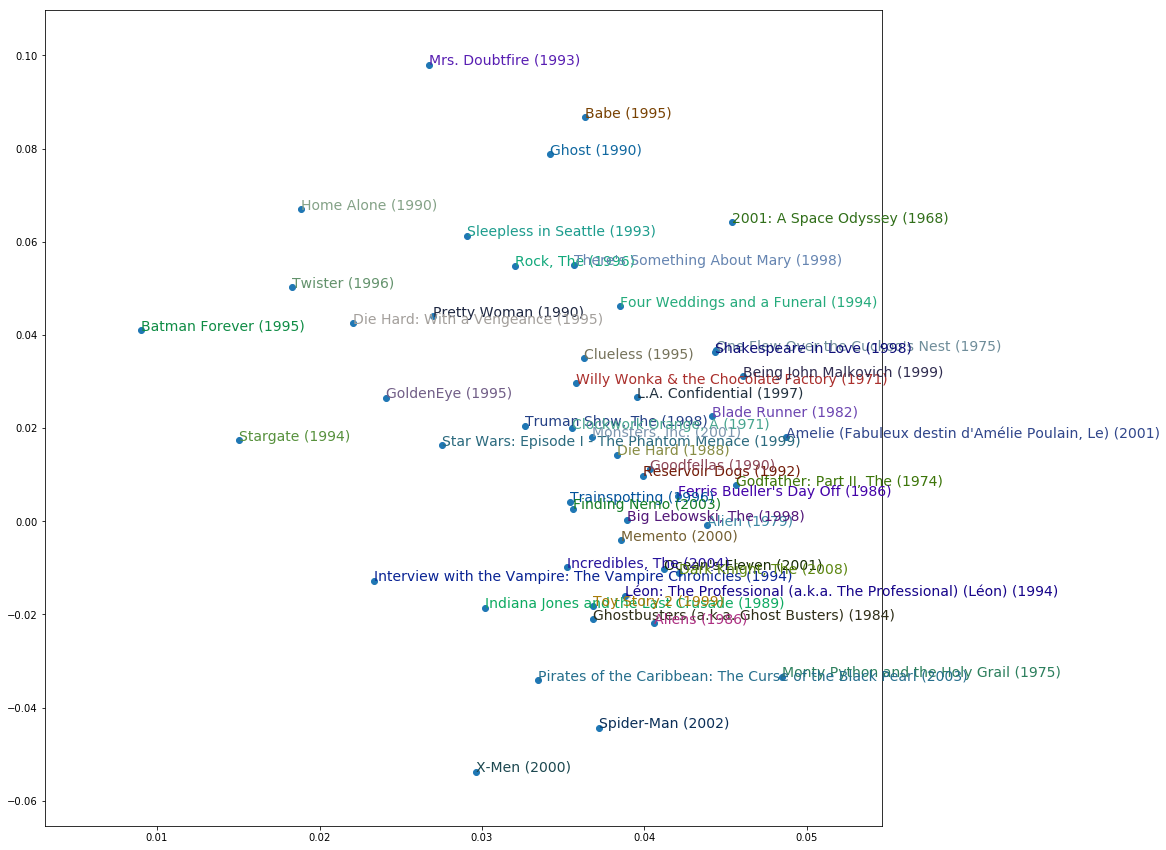

In [60]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [61]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [62]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [63]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=8, verbose=2,
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79769 samples, validate on 20235 samples
Epoch 1/8
8s - loss: 2.4871 - val_loss: 0.9050
Epoch 2/8
8s - loss: 1.4937 - val_loss: 0.8968
Epoch 3/8
8s - loss: 1.2329 - val_loss: 0.8711
Epoch 4/8
8s - loss: 1.0478 - val_loss: 0.8656
Epoch 5/8
8s - loss: 0.9086 - val_loss: 0.8432
Epoch 6/8
8s - loss: 0.8472 - val_loss: 0.8403
Epoch 7/8
8s - loss: 0.8173 - val_loss: 0.8350
Epoch 8/8
8s - loss: 0.8086 - val_loss: 0.8362


This improves on our already impressive accuracy even further!